# Импорт необходимых библиотек

In [1]:
import numpy as np
from scipy.interpolate import make_interp_spline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import re
from pymystem3 import Mystem
from pymorphy3 import MorphAnalyzer

# для интерактивных графиков
from plotly import tools
from plotly import subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

ru_stopwords = stopwords.words('russian')

In [2]:
sns.set_theme()
palette=sns.color_palette('Dark2')
title_fontdict = {'size': 15, 'weight': 'bold'}
suptitle_fontdict = {"size": 13, "color": "green"}

# Загрузка данных

Данные взяты с сайта Banki.ru с помощью собственного парсера.

In [3]:
DB_NAME = 'reviews.db'
DB_PATH = ""

In [4]:
db_connection = sqlite3.connect(DB_PATH + DB_NAME)

df = pd.read_sql_query('SELECT * FROM reviews', db_connection)
db_connection.close()
df.head()

,id,username,bank_name,review_dtt,review_title,review_text,main_grade,clear_conditions_grade,staff_grade,support_grade,app_site_grade,url
0,1,user-482016336916,МТС Банке,14.12.2023 12:36,"Блокировка входа в личный кабинет, приложение ...",\nЗдравствуйте! Проблема войти и разблокироват...,1,1,3,1,3,https://www.banki.ru/services/responses/bank/r...
1,2,user-458916334622,Банке Уралсиб,14.12.2023 09:56,Благодарность,\nХочу выразить огромную признательность сотру...,5,3,3,3,3,https://www.banki.ru/services/responses/bank/r...
2,3,user-471515847583,Совкомбанке,13.12.2023 23:28,Помощь при оплате штрафа,\n03.12.2023 года Я обратилась в отделение Сов...,5,3,3,3,3,https://www.banki.ru/services/responses/bank/r...
3,4,user-888114036692,Банке ДОМ.РФ,14.12.2023 17:14,Благодарность руководителю,\nДобрый день!Хочу выразить благодарность руко...,5,3,3,3,3,https://www.banki.ru/services/responses/bank/r...
4,5,user-679513554131,МТС Банке,14.12.2023 00:22,Банк не разблокирует моб приложение,\nЗдравствуйте12.12 при переводе средств МЕЖДУ...,1,3,3,2,2,https://www.banki.ru/services/responses/bank/r...


In [5]:
df.describe()

,id
count,485280.000000
mean,242640.500000
std,140088.413654
min,1.000000
25%,121320.750000
50%,242640.500000
75%,363960.250000
max,485280.000000


# Предобработка данных

Для начала избавимся от столбцов, которые точно не несут для нас никакой важной информации для подготовки модели: имя пользователя, id. Также избавмися от пропущенных значений. url пригодится, если придётся восстанавливать какие-то данные.

In [6]:
df.drop(df[df['review_text'] == 'miss'].index, inplace=True)
df.drop(columns=['id', 'username'], inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(461321, 10)

Посмотрим, встречаются ли в данных одинаковые записи.

In [7]:
df.duplicated().value_counts()

False    461321
Name: count, dtype: int64

В данных есть один дубликат, удалим его.

In [8]:
df.drop_duplicates(inplace=True)

Изучим атрибуты данных.

In [9]:
df['main_grade'].value_counts()

main_grade
1        240074
5        124574
2         47102
3         20284
4         17447
1.466      6774
4.759      3572
3.388      1494
Name: count, dtype: int64

В данных встречаются отзывы с необычными оценками - 1.466, 4.759 и 3.388. Посмотрим, что это за отзывы

In [10]:
samples_with_strange_grades = [df[df['main_grade'] == 1.466].sample(10),
                               df[df['main_grade'] == 3.388].sample(10), df[df['main_grade'] == 4.759].sample(10)]
pd.concat(samples_with_strange_grades)

,bank_name,review_dtt,review_title,review_text,main_grade,clear_conditions_grade,staff_grade,support_grade,app_site_grade,url
440152,Росбанке,10.03.2006 16:35,"Колхоз, а не банк",\n\tПолгода назад срочно понадобились деньги. ...,1.466,0,0,0,0,https://www.banki.ru/services/responses/bank/r...
437046,Московском кредитном банке,23.06.2007 21:15,Не общаются с клиентами,\n\tДва раза открывала вклад в отделении на Ав...,1.466,0,0,0,0,https://www.banki.ru/services/responses/bank/r...
439712,Ситибанке,27.04.2006 11:54,"Плохо, не ожидала такого","\n\tХотела открыть счет в банке. Казалось бы, ...",1.466,0,0,0,0,https://www.banki.ru/services/responses/bank/r...
436005,Абсолют Банке,23.10.2007 15:19,Игра в конспирацию,\n\tЗлости уже не хватает на этот банк. И само...,1.466,0,0,0,0,https://www.banki.ru/services/responses/bank/r...
439456,Альфа-Банке,31.05.2006 05:23,Western Union по-русски,\n\t26 мая отправлял Вестерн в Германию из отд...,1.466,0,0,0,0,https://www.banki.ru/services/responses/bank/r...
460997,ВТБ,27.09.2005 15:29,Работают - хуже некуда!!!,"\n\tМнение о работе ужасное! Мало того, что вм...",1.466,0,0,0,0,https://www.banki.ru/services/responses/bank/r...
441113,Банке Русский Стандарт,03.11.2005 21:52,"Да ну его, этот РС","\n\tЯ года 2 назад там брал кредит по схеме ""1...",1.466,0,0,0,0,https://www.banki.ru/services/responses/bank/r...
438577,Ситибанке,07.11.2006 15:48,Без комментариев,"\n\tИмел дело со многими банками, но такого ка...",1.466,0,0,0,0,https://www.banki.ru/services/responses/bank/r...
436837,Росэнергобанке,19.07.2007 13:21,Очень плохой банк,"\n\tХуже обслуживания не встречал, чем в Сочин...",1.466,0,0,0,0,https://www.banki.ru/services/responses/bank/r...
441000,Ренессанс Банке,17.11.2005 19:38,Хуже банка просто нет!,\n\tВзял кредит 30 тыс. на покупку компьютера....,1.466,0,0,0,0,https://www.banki.ru/services/responses/bank/r...


По отрывкам с этими оценками явно видно:
* Отзывы с оценкой 1.466 - явно негативные
* Отзывы с оценкой 3.388 - нейтральные
* Отзывы с оценкой 4.759 - положительные
* Эти отзывы старые (до 2009 года)

Соотвественно, мы можем спокойно округлить оценку до ближайшего целого.

In [11]:
df['main_grade'] = df['main_grade'].replace({1.466: 1, 3.388: 3, 4.759: 5})

Посмотрим распределение оценок.

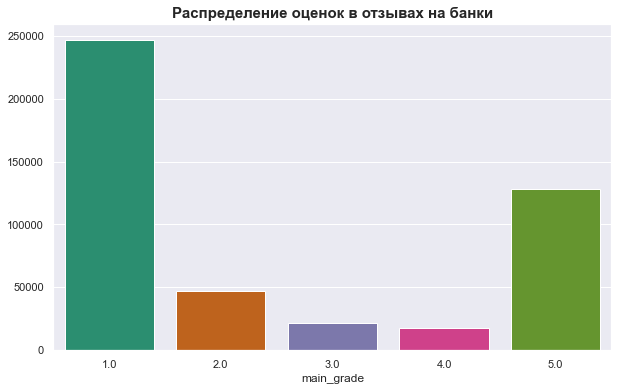

In [12]:
x = df['main_grade'].value_counts().index
y = df['main_grade'].value_counts().values
plt.figure(figsize=(10,6))
p = sns.barplot(x=x, y=y, hue=x,legend=False, palette=palette[:5]) 
p.set_title('Распределение оценок в отзывах на банки', fontdict=title_fontdict)
plt.show()

Видим, что чаще всего на отзывах ставят отрицательную оценку (1), а также положительную (5), промежуточные используются гораздо реже.

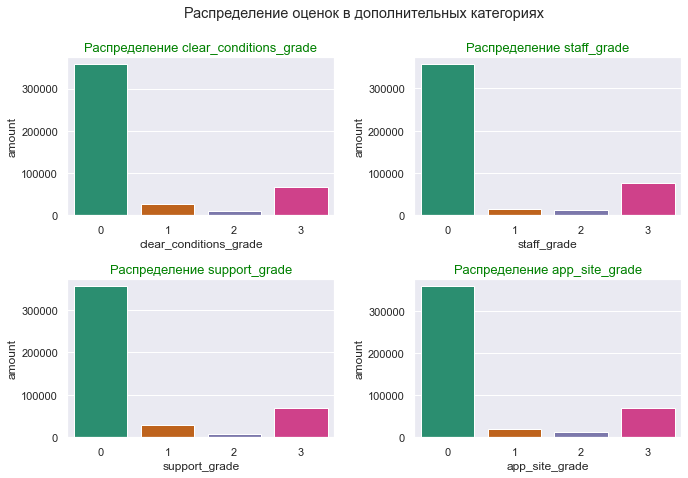

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig.suptitle("Распределение оценок в дополнительных категориях", fontdict=title_fontdict)
additional_grades = [['clear_conditions_grade', 'staff_grade'], 
                     ['support_grade', "app_site_grade"]]
for i in range(2):
    for j in range(2):
        current_grade = additional_grades[i][j]
        x = df[current_grade].value_counts().index
        y = df[current_grade].value_counts().values
        sns.barplot(ax=axes[i][j], x=x, y=y, hue=x, palette=palette[:4], legend=False)
        axes[i][j].set_ylabel("amount")
        axes[i][j].set_title(f"Распределение {current_grade}", fontdict=suptitle_fontdict, loc="center")

    

К сожалению, отзывов с дополнительными оценками очень мало относительно отзывов без них. Удалим эти атрибуты.

In [14]:
to_del = ["clear_conditions_grade", "staff_grade", "support_grade", "app_site_grade"]
df.drop(columns=to_del, inplace=True)
df.head()

,bank_name,review_dtt,review_title,review_text,main_grade,url
0,МТС Банке,14.12.2023 12:36,"Блокировка входа в личный кабинет, приложение ...",\nЗдравствуйте! Проблема войти и разблокироват...,1.0,https://www.banki.ru/services/responses/bank/r...
1,Банке Уралсиб,14.12.2023 09:56,Благодарность,\nХочу выразить огромную признательность сотру...,5.0,https://www.banki.ru/services/responses/bank/r...
2,Совкомбанке,13.12.2023 23:28,Помощь при оплате штрафа,\n03.12.2023 года Я обратилась в отделение Сов...,5.0,https://www.banki.ru/services/responses/bank/r...
3,Банке ДОМ.РФ,14.12.2023 17:14,Благодарность руководителю,\nДобрый день!Хочу выразить благодарность руко...,5.0,https://www.banki.ru/services/responses/bank/r...
4,МТС Банке,14.12.2023 00:22,Банк не разблокирует моб приложение,\nЗдравствуйте12.12 при переводе средств МЕЖДУ...,1.0,https://www.banki.ru/services/responses/bank/r...


Посмотрим количество уникальных банков

In [15]:
print(f"Разных банков в данных: {df['bank_name'].nunique()}")

Разных банков в данных: 765


In [16]:
for el in df["bank_name"].value_counts().index:
    print(el)

Сбербанке
Альфа-Банке
Тинькофф Банке
ВТБ
Совкомбанке
Банке «Открытие»
Хоум Банке
Россельхозбанке
МТС Банке
Газпромбанке
Банке Русский Стандарт
Почта Банке
Московском кредитном банке
Росбанке
ОТП  Банке
Райффайзен Банке
Восточном Банке
Ренессанс Банке
ПСБ
Кредит Европа Банке
ЮниКредит Банке
Уральский банке реконструкции и развития (УБРиР)
Банке «Траст»
Ситибанке
Банке ДОМ.РФ
Банке Уралсиб
Драйв Клик Банке
Модульбанке
банке «Точка»
Банке Авангард
Ак Барс Банке
Связном Банке
Банке Ozon
КИВИ Банке
Банке «Санкт-Петербург»
Абсолют Банке
Азиатско-Тихоокеанском банке
Русфинанс Банке
МОСОБЛБАНКЕ
Локо-Банке
РГС Банке
Юниаструм Банке
БКС Банке
Банке ЗЕНИТ
Банке «Возрождение»
Банке Синара
НКО ЮМани
банке «ДельтаКредит»
Экспобанке
МИнБанке
Банке ТКБ
СМП Банке
Югра
Современном Коммерческом Банке
АйМаниБанке
Банке «Центр-инвест»
Touch Bank
РосинтерБанке
Банке РСБ 24
Ингосстрах Банке
2Т Банке
Пробизнесбанке
Связь-Банке
КБ «Юнистрим»
РНКБ
Инвестторгбанке
СБ Банке
Банке Раунд
Рокетбанке
БНП Париба Банке

В названиях встречаются элементы, которые не спарсились верно, например: "ки.ру</title', "a U-Euro</title".
Посмотрим на строчки в таблице с этими банками.

In [17]:
bad_bank_names = ['ки.ру</title', "a U-Euro</title", 'рация списания с названием "I</title',
                 "ькофф</title", "днократные списания с префиксом I</title", "ькофф, вы лучшие </title",
                " is </title", "али доллары (</title", ]
samples_bad_names = [df[df["bank_name"] == bad_name].sample(1) for bad_name in bad_bank_names]
df_bad_names = pd.concat(samples_bad_names)
df_bad_names

,bank_name,review_dtt,review_title,review_text,main_grade,url
88298,ки.ру</title,04.01.2023 17:53,Банки.ру</title,\nРаботал с этим банком 3 года и горя не знал....,1.0,https://www.banki.ru/services/responses/bank/r...
429916,a U-Euro</title,03.05.2009 00:34,Visa U-Euro</title,"\n\tНу, держитесь, :evil: Ивановское отделени...",1.0,https://www.banki.ru/services/responses/bank/r...
291938,"рация списания с названием ""I</title",04.06.2018 17:00,"Операция списания с названием ""I</title","\n\t04.06.2018 списали деньги с карты, в интер...",1.0,https://www.banki.ru/services/responses/bank/r...
450384,ькофф</title,21.09.2023 23:50,Тинькофф</title,"\nЯ являюсь клиентом Тинькофф, и я не пожалел ...",5.0,https://www.banki.ru/services/responses/bank/r...
295520,днократные списания с префиксом I</title,14.04.2018 21:13,Неоднократные списания с префиксом I</title,\n\tВ третий раз с дебетовой карты списываются...,2.0,https://www.banki.ru/services/responses/bank/r...
243081,"ькофф, вы лучшие </title",01.12.2019 14:59,"Тинькофф, вы лучшие </title",\n\tЯвляюсь клиентом Тинькофф банка уже 4-5 ле...,5.0,https://www.banki.ru/services/responses/bank/r...
401669,is </title,12.01.2013 20:24,TCS is </title,\n\tЯвляюсь клиентом уже год. Мой любимый банк...,5.0,https://www.banki.ru/services/responses/bank/r...
129227,али доллары (</title,04.04.2022 18:16,Выдали доллары (</title,\n\tВ конце марта заканчивался долларовый вкла...,5.0,https://www.banki.ru/services/responses/bank/r...


Изучим эти отзывы вручную по URL

In [18]:
df_bad_names['url'].values

array(['https://www.banki.ru/services/responses/bank/response/10814289',
       'https://www.banki.ru/services/responses/bank/response/1033525',
       'https://www.banki.ru/services/responses/bank/response/10164546',
       'https://www.banki.ru/services/responses/bank/response/11106625',
       'https://www.banki.ru/services/responses/bank/response/10151650',
       'https://www.banki.ru/services/responses/bank/response/10325520',
       'https://www.banki.ru/services/responses/bank/response/4435434',
       'https://www.banki.ru/services/responses/bank/response/10644443'],
      dtype=object)

У этих отзывов нестандартный заголовок, поэтому парсер сработал на них неверно. Посмотрим, сколько их всего.

In [19]:
samples_bad_names = [df[df["bank_name"] == bad_name] for bad_name in bad_bank_names]
df_bad_names = pd.concat(samples_bad_names)
print(f"Отзывов с плохими названиями банков: {df_bad_names.shape[0]}")

Отзывов с плохими названиями банков: 17


Таких отзывов всего 17 штук. Помимо неправильного названия банка в них ещё встречается неправильный заголовок, поэтому можем смело от них избавиться.

In [20]:
df.drop(df_bad_names.index, inplace=True)

В названиях банков слово "банк" часто записано с окончанием "е", исправим это.

In [21]:
df["bank_name"] = df["bank_name"].apply(lambda x: x.replace("Банке", 'Банк').replace("банке", 'банк').replace('БАНКЕ', "БАНК"))
df["bank_name"].sample(10)

289211                     Почта Банк
28889                      Альфа-Банк
300394                     Почта Банк
93911                   Тинькофф Банк
422650                       Сбербанк
436476         банк «Нефтяной Альянс»
460774                           Югра
206769    Азиатско-Тихоокеанском банк
377850                 Русфинанс Банк
47237                      Альфа-Банк
Name: bank_name, dtype: object

In [22]:
df.sample(10)

,bank_name,review_dtt,review_title,review_text,main_grade,url
186614,Банк ДОМ.РФ,02.02.2021 10:37,Очень сложная ипотека в ДОМ.РФ,\n\tЕсли говорить в целом об отношении к данно...,1.0,https://www.banki.ru/services/responses/bank/r...
76185,Кредит Европа Банк,22.03.2023 14:08,Благодарность,\n\tДобрый день! Хочу выразить искреннюю благо...,5.0,https://www.banki.ru/services/responses/bank/r...
131191,Райффайзен Банк,22.03.2022 12:54,Банк не получает корреспонденцию,\n\t16.03.2022 г. на юридический адрес Банка (...,1.0,https://www.banki.ru/services/responses/bank/r...
228639,ВТБ,10.04.2020 20:10,Обман со ставкой по кредиту,\n\tЗаполнил онлайн заявку на рефинансирование...,1.0,https://www.banki.ru/services/responses/bank/r...
28664,ВТБ,13.09.2023 14:23,Банк не меняется,"\nБанк ВТБ к сожалению, не меняется. 2 года на...",1.0,https://www.banki.ru/services/responses/bank/r...
286027,ВТБ,17.08.2018 17:48,Приятное удивление,\n\tДобрый день!Обратилась в банк ВТБ на Римск...,5.0,https://www.banki.ru/services/responses/bank/r...
337640,Сбербанк,18.07.2016 03:20,Аварийный чек и незачисление денежных средств ...,\n\t08.07.2016 г. пополнял счет своей банковск...,1.0,https://www.banki.ru/services/responses/bank/r...
24820,МТС Банк,21.09.2023 17:21,"Три часа бесполезных разговоров, а счет так и ...",\nОбнаружив в ЛК налоговой незакрытый счет аж ...,1.0,https://www.banki.ru/services/responses/bank/r...
140133,Уральский банк реконструкции и развития (УБРиР),04.01.2022 16:18,Банк после погашения не закрывает кредитный до...,"\n\tБрал потребительский кредит в банке УБРиР,...",1.0,https://www.banki.ru/services/responses/bank/r...
131590,Альфа-Банк,19.03.2022 10:18,Обман по кредитной карте!,\n\tТакого обмана я не видела ни в одном банке...,1.0,https://www.banki.ru/services/responses/bank/r...


Достанем дату и время из колонки review_dtt

In [23]:
df['review_dtt'] = pd.to_datetime(df['review_dtt'], format="%d.%m.%Y %H:%M")
df['review_year'] = df['review_dtt'].apply(lambda x: x.year)
df['review_month'] = df['review_dtt'].apply(lambda x: x.month)
df['review_day'] = df['review_dtt'].apply(lambda x: x.day)
df['review_hour'] = df['review_dtt'].apply(lambda x: x.hour)
df.head()

,bank_name,review_dtt,review_title,review_text,main_grade,url,review_year,review_month,review_day,review_hour
0,МТС Банк,2023-12-14 12:36:00,"Блокировка входа в личный кабинет, приложение ...",\nЗдравствуйте! Проблема войти и разблокироват...,1.0,https://www.banki.ru/services/responses/bank/r...,2023,12,14,12
1,Банк Уралсиб,2023-12-14 09:56:00,Благодарность,\nХочу выразить огромную признательность сотру...,5.0,https://www.banki.ru/services/responses/bank/r...,2023,12,14,9
2,Совкомбанк,2023-12-13 23:28:00,Помощь при оплате штрафа,\n03.12.2023 года Я обратилась в отделение Сов...,5.0,https://www.banki.ru/services/responses/bank/r...,2023,12,13,23
3,Банк ДОМ.РФ,2023-12-14 17:14:00,Благодарность руководителю,\nДобрый день!Хочу выразить благодарность руко...,5.0,https://www.banki.ru/services/responses/bank/r...,2023,12,14,17
4,МТС Банк,2023-12-14 00:22:00,Банк не разблокирует моб приложение,\nЗдравствуйте12.12 при переводе средств МЕЖДУ...,1.0,https://www.banki.ru/services/responses/bank/r...,2023,12,14,0


Добавим атрибут sentiment - в нём разделим отзывы на негативные [1-3] и позитивные [4-5]. Это будет наш главный признак.

In [24]:
df['sentiment'] = df['main_grade'].apply(lambda x: 'positive' if x > 3 else 'negative')

теперь можем избавиться от url и review_dtt и main_grade.

In [25]:
df.drop(columns=['review_dtt', "url", "main_grade"], inplace=True)

Добавим атрибут с длиной отзыва и атрибут с длиной заголовка.

In [26]:
df['title_len'] = df['review_title'].apply(lambda x: len(x))
df['review_len'] = df['review_text'].apply(lambda x: len(x))
df.head()

,bank_name,review_title,review_text,review_year,review_month,review_day,review_hour,sentiment,title_len,review_len
0,МТС Банк,"Блокировка входа в личный кабинет, приложение ...",\nЗдравствуйте! Проблема войти и разблокироват...,2023,12,14,12,negative,55,1561
1,Банк Уралсиб,Благодарность,\nХочу выразить огромную признательность сотру...,2023,12,14,9,positive,13,418
2,Совкомбанк,Помощь при оплате штрафа,\n03.12.2023 года Я обратилась в отделение Сов...,2023,12,13,23,positive,24,461
3,Банк ДОМ.РФ,Благодарность руководителю,\nДобрый день!Хочу выразить благодарность руко...,2023,12,14,17,positive,26,495
4,МТС Банк,Банк не разблокирует моб приложение,\nЗдравствуйте12.12 при переводе средств МЕЖДУ...,2023,12,14,0,negative,35,504


In [27]:
df.reset_index(inplace=True, drop=True)

# Анализ данных

Посмотрим, как часто разные банки встречаются в данных

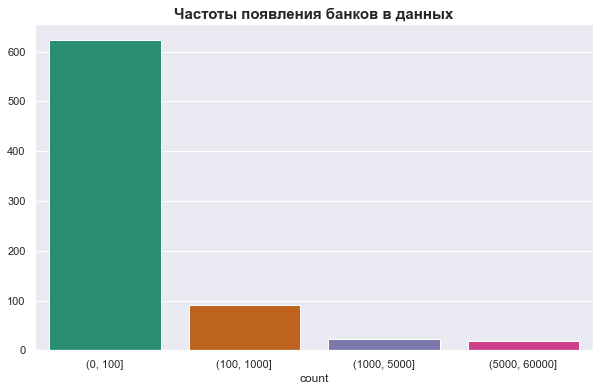

In [28]:
bins = [0, 100, 1000, 5000, 60000]
s = pd.cut(df['bank_name'].value_counts(), bins=bins).value_counts()
x = s.index
y = s.values
plt.figure(figsize=(10,6))
p = sns.barplot(x=x, y=y, hue=x,legend=False, palette=palette[:4]) 
p.set_title('Частоты появления банков в данных', fontdict=title_fontdict)
plt.show()

Большинство банков фигурируют в отзывах менее ста раз.

Text(0.5, 1.0, 'Доля отзывов по банкам')

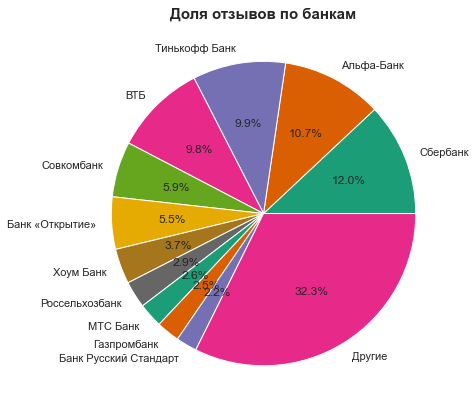

In [29]:
s = df['bank_name'].value_counts()
s['Другие']= 0
for i in range(len(s)):
    if s.iloc[i] <= 10000:
        s['Другие'] += s.iloc[i]
s = s[s > 10000]
plt.figure(figsize=(10, 7))
plt.pie(s, labels=s.index, radius=1, colors=palette, autopct='%.1f%%')
plt.title("Доля отзывов по банкам", fontdict=title_fontdict)

In [30]:
s.iloc[:11]

bank_name
Сбербанк                 55288
Альфа-Банк               49326
Тинькофф Банк            45522
ВТБ                      45170
Совкомбанк               27215
Банк «Открытие»          25594
Хоум Банк                17228
Россельхозбанк           13166
МТС Банк                 11975
Газпромбанк              11375
Банк Русский Стандарт    10269
Name: count, dtype: int64

In [31]:
s.iloc[:5].values

array([55288, 49326, 45522, 45170, 27215], dtype=int64)

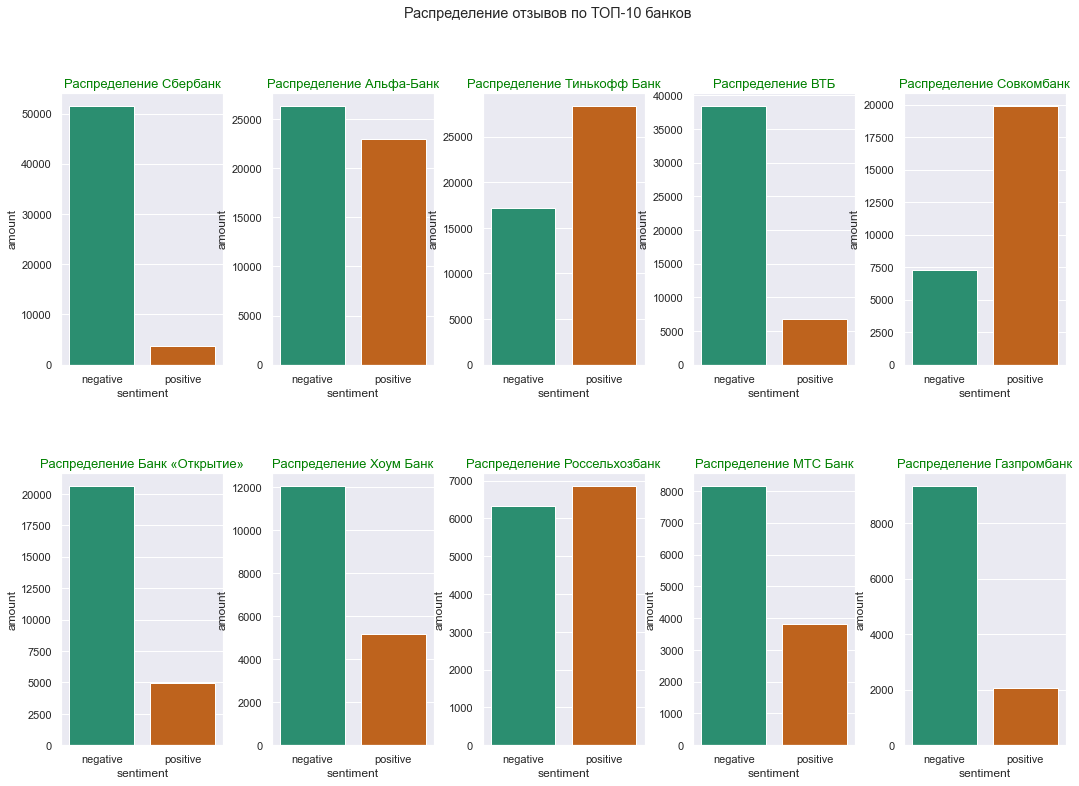

In [32]:
fig, axes = plt.subplots(2, 5, figsize=(18, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig.suptitle("Распределение отзывов по ТОП-10 банков", fontdict=title_fontdict)
top_banks = [s.iloc[:5], s.iloc[5:11]]
for i in range(2):
    for j in range(5):
        current_bank = top_banks[i].index[j]
        current_sentiment = df[df['bank_name'] == current_bank]['sentiment'].value_counts().sort_index()
        x = current_sentiment.index
        y = current_sentiment.values
        sns.barplot(ax=axes[i][j], x=x, y=y, hue=x, palette=palette[:2], legend=False)
        axes[i][j].set_ylabel("amount")
        axes[i][j].set_title(f"Распределение {current_bank}", fontdict=suptitle_fontdict, loc="center")


По графику видим, что самое негативное соотношение - у СберБанка и ВТБ. Самое позитивное - у Совкомбанка и Тинькофф Банка.

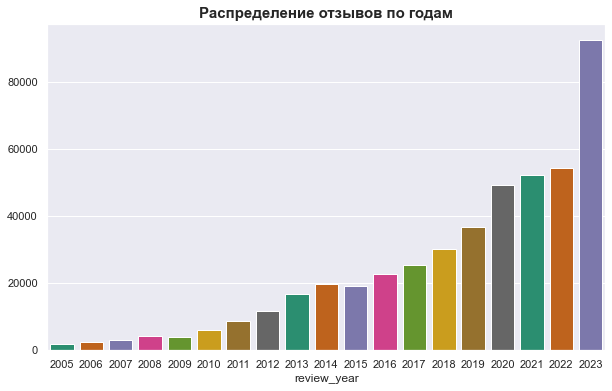

In [33]:
x = df['review_year'].value_counts().index
y = df['review_year'].value_counts().values
plt.figure(figsize=(10,6))
p = sns.barplot(x=x, y=y, hue=x,legend=False, palette=palette*2+palette[:3])
p.set_title('Распределение отзывов по годам', fontdict=title_fontdict)
plt.show()

По графику видим, что количество отзывов растёт с каждым годом. В 2023 году число возросло почти в два раза по сравнению с 2022.

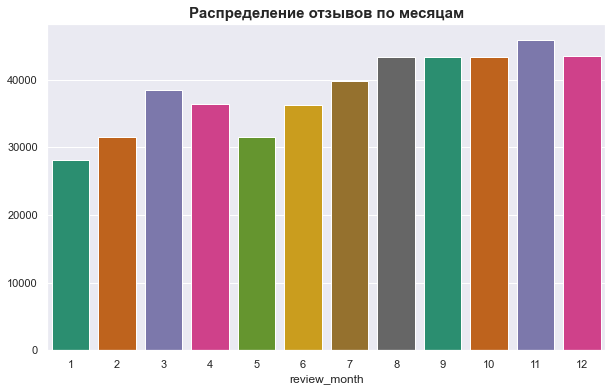

In [34]:
x = df['review_month'].value_counts().index
y = df['review_month'].value_counts().values
plt.figure(figsize=(10,6))
p = sns.barplot(x=x, y=y, hue=x,legend=False, palette=palette+palette[:4])
p.set_title('Распределение отзывов по месяцам', fontdict=title_fontdict)
plt.show()

Во второй половине года оставляют больше отзывов, чем в первой.

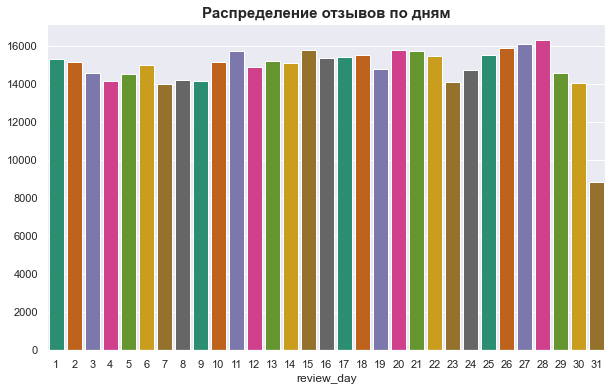

In [35]:
x = df['review_day'].value_counts().index
y = df['review_day'].value_counts().values
plt.figure(figsize=(10,6))
p = sns.barplot(x=x, y=y, hue=x,legend=False, palette=palette*3+palette[:7])
p.set_title('Распределение отзывов по дням', fontdict=title_fontdict)
plt.show()

По дням распределение примерно равное, не учитывая 29, 30 и 31 чисел - чисел, которые встречаются не в каждом месяце.

In [36]:
mood_group = df[['sentiment', "title_len", 'review_len']].groupby('sentiment').mean()

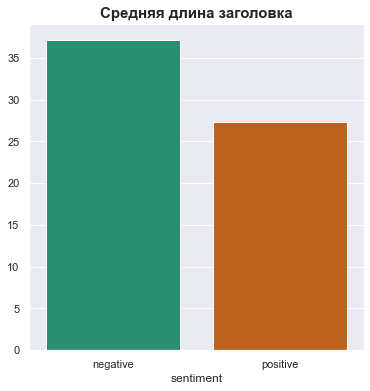

In [37]:
x = mood_group['title_len'].index
y = mood_group['title_len'].values
plt.figure(figsize=(6,6))
p = sns.barplot(x=x, y=y, hue=x,legend=False, palette=palette[:2]) 
p.set_title('Средняя длина заголовка', fontdict=title_fontdict)
plt.show()

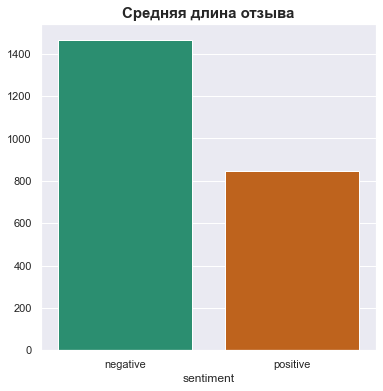

In [38]:
x = mood_group['review_len'].index
y = mood_group['review_len'].values
plt.figure(figsize=(6,6))
p = sns.barplot(x=x, y=y, hue=x,legend=False, palette=palette[:2]) 
p.set_title('Средняя длина отзыва', fontdict=title_fontdict)
plt.show()

По графикам видно, что в негативных отзывах заголовок и текст самого отзыва в среднем длиннее, чем у позитивного (примерно в 1.5-2 раза)

## Подготовка данных к модели

Заменим negative и positive в sentiment на 0 и 1. Избавимся от атрибутов, которые не понадобятся нашей модели. Оставим заголовок отзыва, текст отзыва, длину заголовка и текста и настроение отзыва.

In [39]:
df.drop(columns=["bank_name", 'review_year', 'review_month', 'review_day', 'review_hour'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [40]:
df['sentiment'] = df['sentiment'].replace({'negative': 0, "positive": 1})

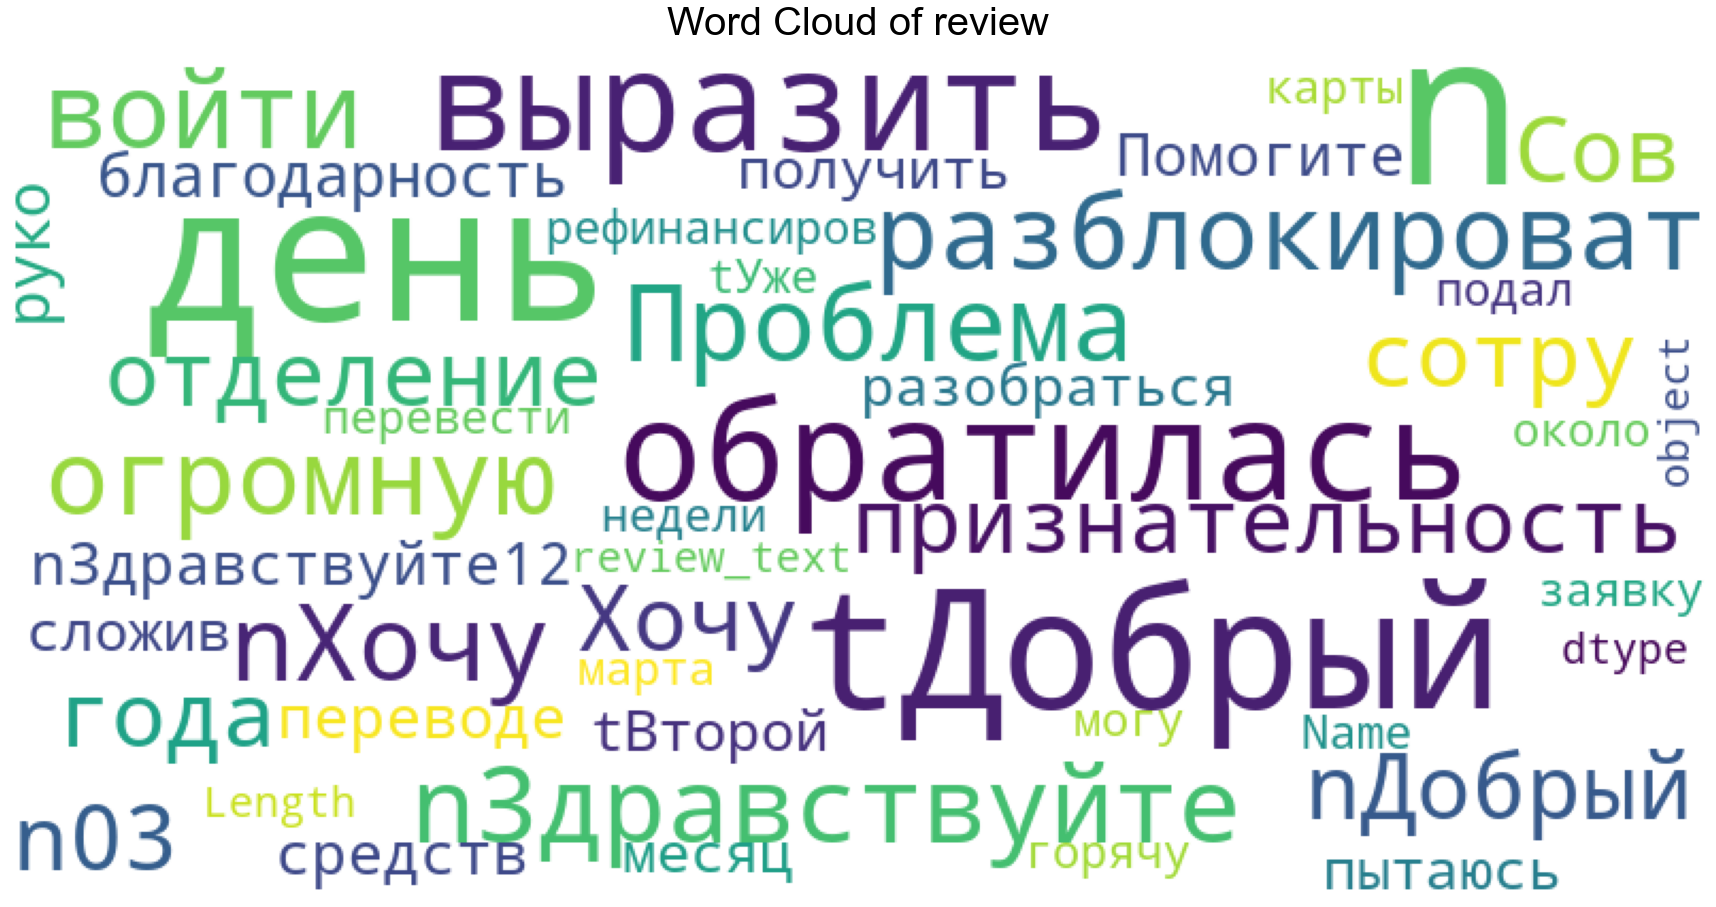

In [41]:
# сделаем Word Cloud по нашим review
# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    
    wordcloud = WordCloud(background_color='white',
                    stopwords = ru_stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df["review_text"], title="Word Cloud of review")

Обработаем отзывы: избавимся от знаков пунктуации и стоп слов, лемматизируем слова и приведём их к нижнему регистру.

In [42]:
df['review_text'] = df['review_text'].apply(lambda x: x.replace('\n', '').replace('\t', '').replace('\xa0', ''))

In [43]:
morph = MorphAnalyzer()

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^а-яА-Я]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 4. Stopwords 
    meaningful_words = [w for w in words if not w in ru_stopwords]
    # 5. Stemming
    lemmas = [morph.parse(word)[0].normal_form for word in meaningful_words]
    # 6. space join words
    return( ' '.join(lemmas))

In [44]:
%time df['review_text'] = df['review_text'].apply(review_to_words)

Wall time: 3h 18min 40s


In [45]:
%time df['review_title'] = df['review_title'].apply(review_to_words)

C:\Users\artem\Anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning:

"https://www.banki.ru/services/responses/bank/rshb/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.



Wall time: 8min 42s


In [50]:
df.head()

,review_title,review_text,sentiment,title_len,review_len
0,блокировка вход личный кабинет приложение мтс ...,здравствуйте проблема войти разблокировать лич...,0,55,1561
1,благодарность,хотеть выразить огромный признательность сотру...,1,13,418
2,помощь оплата штраф,год обратиться отделение совкомбанк адрес г са...,1,24,461
3,благодарность руководитель,добрый день хотеть выразить благодарность руко...,1,26,495
4,банк разблокировать моб приложение,здравствуйте перевод средство свой счёт банк з...,0,35,504


In [48]:
df.to_csv("lemmatizied.csv")

In [3]:
df = pd.read_csv("lemmatizied.csv", index_col=0)
df = df.astype({"review_text": str})
df.head()

,review_title,review_text,sentiment,title_len,review_len
0,блокировка вход личный кабинет приложение мтс ...,здравствуйте проблема войти разблокировать лич...,0,55,1561
1,благодарность,хотеть выразить огромный признательность сотру...,1,13,418
2,помощь оплата штраф,год обратиться отделение совкомбанк адрес г са...,1,24,461
3,благодарность руководитель,добрый день хотеть выразить благодарность руко...,1,26,495
4,банк разблокировать моб приложение,здравствуйте перевод средство свой счёт банк з...,0,35,504


Объединим колонки с заголовком и текстом в одну.

In [4]:
df['combined_text'] = df['review_title'] + " " + df['review_text']
df.drop(columns=['review_title', 'review_text'], inplace=True)
df.dropna(inplace=True)

## Деление на тестовую и обучающую выборку

In [5]:
from sklearn.model_selection import train_test_split

X = df["combined_text"]
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape

(308427,)

In [6]:
X_train.head()

47062     решение проблема ошибочный платёж очень приятн...
805       обман направиться офис россельхозбанк адрес г ...
88204     двойной списание средство произойти двойной сп...
401956    дезинформация прежде хотеть поблагодарить банк...
316981    плохой представить огромный сожаление наш комп...
Name: combined_text, dtype: object

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=1,use_idf=True,ngram_range=(1,3))

#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)
#transformed test reviews
tv_test_reviews=tv.transform(X_test)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (308427, 29826248)
Tfidf_test: (151913, 29826248)


In [44]:
tv_train_reviews

<308427x29826248 sparse matrix of type '<class 'numpy.float64'>'
	with 99007257 stored elements in Compressed Sparse Row format>

# Обучение модели

Попробуем различные модели для выявления самой эффективной.

In [45]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
model = SGDClassifier(loss='hinge')
model.fit(tv_train_reviews,y_train)
print(classification_report(y_test,model.predict(tv_test_reviews)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96    103971
           1       0.98      0.83      0.90     47942

    accuracy                           0.94    151913
   macro avg       0.96      0.91      0.93    151913
weighted avg       0.94      0.94      0.94    151913


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
params = {
    "loss" : ["hinge"],
    #"alpha" : [0.1],
    #"penalty" : ["l2"],
    'class_weight' : [None],
    'warm_start' : [True],
    'learning_rate' :['adaptive'],
    'eta0' : [0.001],
    #'power_t' :[0.0001],
    'early_stopping' : [True],
    #'validation_fraction' : [0.001]

}

model = SGDClassifier(max_iter=2000)
clf = GridSearchCV(model, param_grid=params)
clf.fit(tv_train_reviews,y_train)
print(classification_report(y_test,clf.predict(tv_test_reviews)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95    103971
           1       0.98      0.80      0.89     47942

    accuracy                           0.93    151913
   macro avg       0.95      0.90      0.92    151913
weighted avg       0.94      0.93      0.93    151913


In [22]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()

clf.fit(tv_train_reviews,y_train)
print(classification_report(y_test,clf.predict(tv_test_reviews)))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    103971
           1       0.90      0.83      0.86     47942

    accuracy                           0.92    151913
   macro avg       0.91      0.89      0.90    151913
weighted avg       0.91      0.92      0.91    151913


In [24]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(model)
param_grid = {
    'n_estimators': [5, 10, 15],
    'max_samples' : [0.6, 0.8, 1.0],
}
clf = GridSearchCV(clf, param_grid=param_grid)
clf.fit(tv_train_reviews,y_train)
print(classification_report(y_test,clf.best_estimator_.predict(tv_test_reviews)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96    103971
           1       0.98      0.83      0.90     47942

    accuracy                           0.94    151913
   macro avg       0.96      0.91      0.93    151913
weighted avg       0.94      0.94      0.94    151913


In [40]:
from sklearn.feature_extraction.text import CountVectorizer

tv = CountVectorizer(min_df=1,ngram_range=(1,3))

#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)
#transformed test reviews
tv_test_reviews=tv.transform(X_test)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (308427, 29826248)
Tfidf_test: (151913, 29826248)


In [41]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_idf_transformer = TfidfTransformer()

tv_train_reviews_tf_idf = tf_idf_transformer.fit_transform(tv_train_reviews)
tv_test_reviews_tf_idf = tf_idf_transformer.transform(tv_test_reviews)

In [42]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
model = SGDClassifier(loss='hinge')
model.fit(tv_train_reviews_tf_idf,y_train)
print(classification_report(y_test,model.predict(tv_test_reviews_tf_idf)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96    103971
           1       0.98      0.83      0.90     47942

    accuracy                           0.94    151913
   macro avg       0.96      0.91      0.93    151913
weighted avg       0.94      0.94      0.94    151913


## Выгрузка модели

In [46]:
import pickle
with open('./tf_idf_vect.pkl','wb') as file:
    pickle.dump(tv,file)
with open('./model.pkl', 'wb') as file:
    pickle.dump(model, file)